# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

In [0]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
from scipy import special, optimize
from matplotlib import style
import squarify
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: ignored

In [0]:
!pip install squarify

In [0]:
from google.colab import files
uploaded = files.upload()

Saving train_transaction.csv.zip to train_transaction.csv.zip
Saving train_identity.csv.zip to train_identity.csv.zip


Import Dataset 

In [0]:
df_train_identity = pd.read_csv('train_identity.csv.zip')
df_train_transaction = pd.read_csv('train_transaction.csv.zip')

Creating Data Frame for questions 1-5

In [0]:
df_transaction_limited = df_train_transaction[['isFraud','TransactionID', 'TransactionDT', 'TransactionAmt','ProductCD','card4','card6','P_emaildomain','R_emaildomain','addr1','addr2','dist1', 'dist2']]
df_identity_limited = df_train_identity[['DeviceType', 'DeviceInfo','TransactionID']]

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [0]:
# Create separate datasets for fraudulent and non fraudulent transactions 
df_transaction_fraud = df_transaction_limited.loc[df_transaction_limited['isFraud'] == 1]
df_transaction_nonfraud = df_transaction_limited.loc[df_transaction_limited['isFraud'] == 0]

# Merege Identities Dataframe with Fraudulent and Non Fraudulent Data Frames on TransactionID
df_all_fraud = pd.merge(df_transaction_fraud,df_identity_limited , on='TransactionID', how = 'outer')
df_all_nonfraud = pd.merge(df_transaction_nonfraud,df_identity_limited , on='TransactionID', how = 'outer')

### Distribution of Transaction Amount

Examiniming the distribution of transaction amount through a probability distribution plot (KDE) and through Histograms 

In [0]:
def plot_df_kde(df):
  ax = df.plot.kde(bw_method=0.3)
  ax.set_xscale('log')
  ax.set(xlim=(1, 100000))

Text(0.5, 1.0, 'Distribution of fraud and non-fraud transactions by taking log of Transactions Amount')

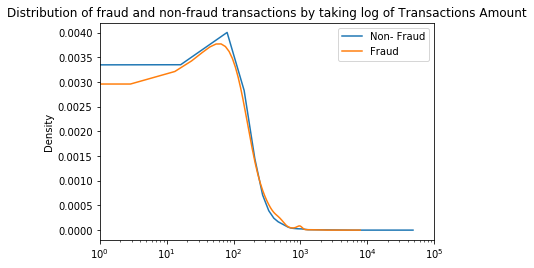

In [0]:
df_TransactionAmt =  pd.DataFrame({'Non- Fraud': df_transaction_nonfraud['TransactionAmt'],'Fraud': df_transaction_fraud['TransactionAmt']})
plot_df_kde(df_TransactionAmt)
plt.title('Distribution of fraud and non-fraud transactions by taking log of Transactions Amount')

Normalised Histrogram plot for Transaction Amount

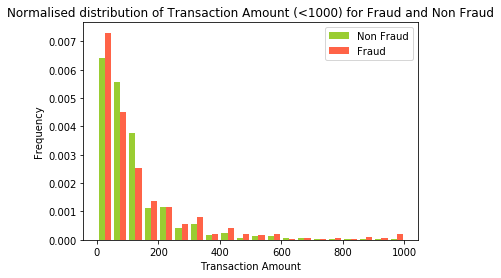

In [0]:
non_f_t = df_transaction_nonfraud['TransactionAmt']
legend = ['Non Fraud', 'Fraud']
f_t = df_transaction_fraud['TransactionAmt']
plt.hist([non_f_t, f_t], density =  True, range = (0,1000), bins = 20,color=[ 'yellowgreen', 'tomato'])
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.legend(legend)
plt.title('Normalised distribution of Transaction Amount (<1000) for Fraud and Non Fraud')
plt.show()

### Distribution of Device Type

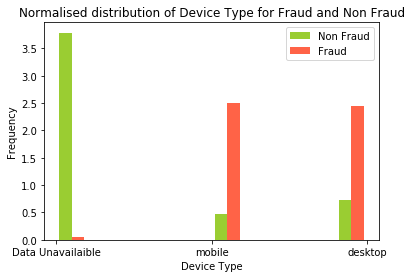

In [0]:
non_f_d = df_all_nonfraud["DeviceType"]
non_f_d = non_f_d.fillna("Data Unavailaible")
legend = ['Non Fraud', 'Fraud']
f_d = df_all_fraud["DeviceType"]
f_d = f_d.fillna("Data Unavailaible")
plt.hist([non_f_d, f_d], density =  True, color=[ 'yellowgreen', 'tomato'])
plt.xlabel("Device Type")
plt.ylabel("Frequency")
plt.legend(legend)
plt.title('Normalised distribution of Device Type for Fraud and Non Fraud')
plt.show()

#### Distribution of Device Info

In [0]:
# Function to plot Treemap for Device Info 
def plot_tree_map(fraud_flag):
  if fraud_flag == True:
    df_temp = df_all_fraud["DeviceInfo"].value_counts()
    
  else:
    df_temp= df_all_nonfraud["DeviceInfo"].value_counts()
  df_temp = df_temp.reset_index()
  sns.set()
  plt.rcParams['figure.figsize'] = (14.0, 7.0)
  style.use('ggplot')

  # Device Percentage 
  df_temp = df_temp.sort_values(by="DeviceInfo", ascending=False)
  df_temp["Percentage"] = round(100 * df_temp["DeviceInfo"] / sum(df_temp["DeviceInfo"]), 2)

  # Create Treemap Labels
  df_temp["Label"] = df_temp["index"] + " (" + df_temp["Percentage"].astype("str") + "%)"
  df_temp = df_temp[0:10]
  print(df_temp['index'])
  # Get Axis and Figure
  fig, ax = plt.subplots()

  cmap = plt.cm.coolwarm
  mini = min(df_temp["DeviceInfo"])
  maxi = max(df_temp["DeviceInfo"])
  norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
  colors = [cmap(norm(value)) for value in df_temp["DeviceInfo"]]
  squarify.plot(sizes=df_temp["DeviceInfo"], label=df_temp["Label"], alpha=0.8, color=colors)
  plt.axis('off')
  plt.gca().invert_yaxis()
     

0                      Windows
1                   iOS Device
2                        MacOS
3       hi6210sft Build/MRA58K
4        SM-A300H Build/LRX22G
5                      rv:57.0
6                  Trident/7.0
7                      rv:11.0
8    LG-D320 Build/KOT49I.V10a
9        SM-J700M Build/MMB29K
Name: index, dtype: object


Text(0.5, 1.0, 'Distribution of Frauduelent Device Info ')

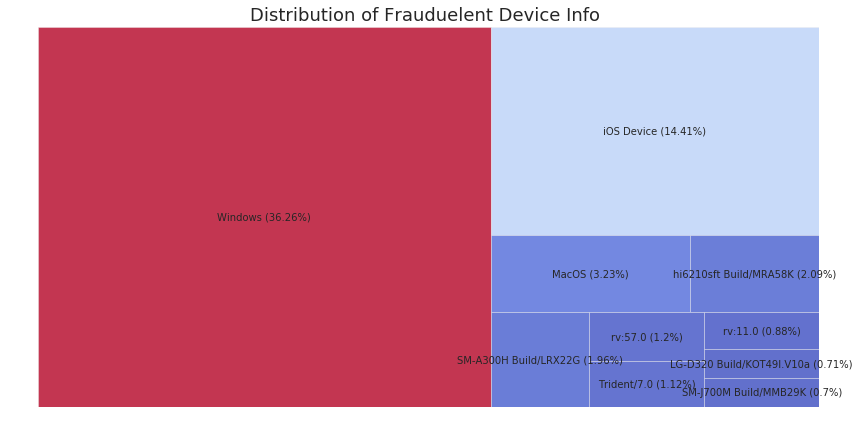

In [0]:
plot_tree_map(True)
plt.title("Distribution of Frauduelent Device Info ", fontsize=18)


0                  Windows
1               iOS Device
2                    MacOS
3              Trident/7.0
4                  rv:11.0
5                  rv:57.0
6    SM-J700M Build/MMB29K
7    SM-G610M Build/MMB29K
8    SM-G531H Build/LMY48B
9                  rv:59.0
Name: index, dtype: object


Text(0.5, 1.0, 'Distribution of Non-Frauduelent Device Info ')

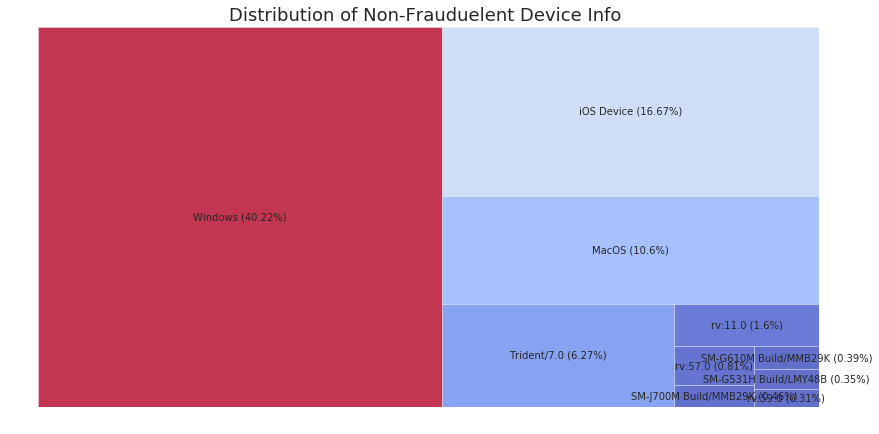

In [0]:
plot_tree_map(False)
plt.title("Distribution of Non-Frauduelent Device Info ", fontsize=18)

#### TransactionID

Text(0.5, 1.0, 'Distribution of fraud and non-fraud transaction IDS ')

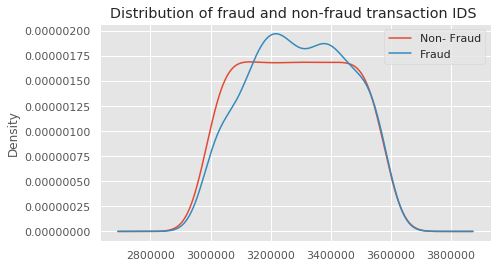

In [0]:
df_TransactionID =  pd.DataFrame({'Non- Fraud': df_transaction_nonfraud['TransactionID'],'Fraud': df_transaction_fraud['TransactionID']})
plt.rcParams['figure.figsize'] = (7.0, 4.0)
ax = df_TransactionID.plot.kde(bw_method=0.3)
plt.title('Distribution of fraud and non-fraud transaction IDS ')

#### ProductCD

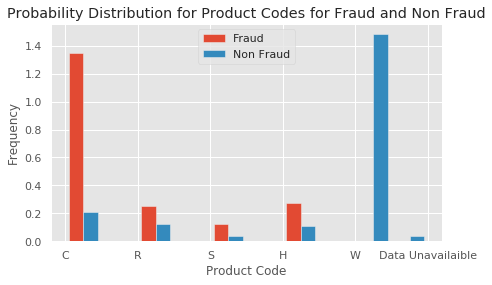

In [0]:
non_f_d = df_all_nonfraud["ProductCD"]
non_f_d = non_f_d.fillna("Data Unavailaible")
legend = [ 'Fraud','Non Fraud']
f_d = df_all_fraud['ProductCD']
f_d = f_d.fillna("Data Unavailaible")
plt.hist([f_d,non_f_d], density =  True)
plt.xlabel("Product Code")
plt.ylabel("Frequency")
plt.legend(legend)
plt.title('Probability Distribution for Product Codes for Fraud and Non Fraud')
plt.show()

#### Card 4 

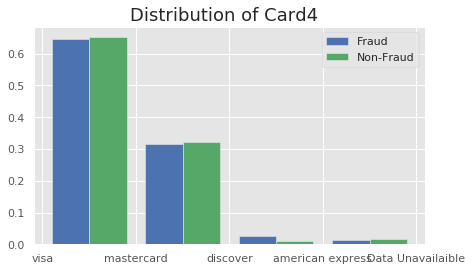

In [0]:
plt.style.use('seaborn-deep')

x = df_transaction_fraud["card4"]
x = x.fillna("Data Unavailaible")
y = df_transaction_nonfraud["card4"]
y = y.fillna("Data Unavailaible")
#bins = np.linspace(0, 500, 6)

weights = np.ones_like(x)/float(len(x))

#print(np.unique(x))
plt.hist([x, y],  label=['Fraud', 'Non-Fraud'], density = True, bins = 4)
plt.legend(loc='upper right')
plt.title("Distribution of Card4  ", fontsize=18)    
plt.show()

#### Card 6

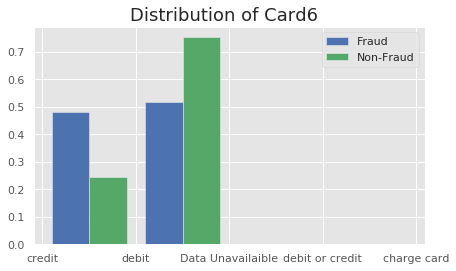

In [0]:
plt.style.use('seaborn-deep')

x = df_transaction_fraud["card6"]
x = x.fillna("Data Unavailaible")
y = df_transaction_nonfraud["card6"]
y = y.fillna("Data Unavailaible")
#print(np.unique(x))

plt.hist([x,y],  label=['Fraud', 'Non-Fraud'], density = True, histtype='bar', bins = 4)
plt.legend(loc='upper right')
plt.title("Distribution of Card6  ", fontsize=18)    
plt.show()

**TransactionDT**

Text(0.5, 1.0, 'Plot of Transaction DT')

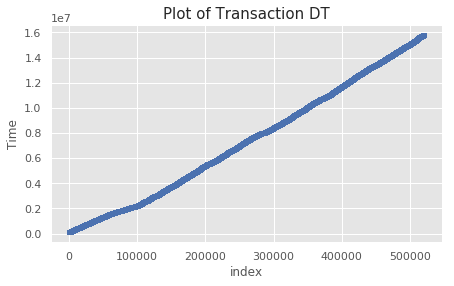

In [0]:
plt.rcParams['figure.figsize'] = (7.0, 4)
df_temp.plot(x ='index', y='Time', kind = 'scatter')
plt.title('Plot of Transaction DT', fontsize=15)  

#### P_Email Domain

In [0]:
def get_bar_p(x,y):
  plt.style.use('seaborn-deep')
  plt.rcParams['figure.figsize'] = (14,7.0)
  x = x.fillna("NAN")
  y = y.fillna("NAN")
  counts_y = Counter(y)
  labels_y, values_y = zip(*counts_y.items())

  # sort your values in descending order
  indSort = np.argsort(values_y)[::-1]

  # rearrange your data
  labels_y = np.array(labels_y)[indSort]
  values_y = np.array(values_y)[indSort]

  labels_y = labels_y[0:9]
  values_y = values_y[0:9]
  sum_y = np.sum(values_y)
  values_y = np.true_divide(values_y, sum_y)
  indexes_y = np.arange(len(labels_y))

  counts = Counter(x)
  labels, values = zip(*counts.items())
  # sort your values in descending order
  indSort = np.argsort(values)[::-1]

  # rearrange your data
  labels = np.array(labels)[indSort]
  values = np.array(values)[indSort]
  labels = labels[0:9]
  values = values[0:9]
  sum_x = np.sum(values)
  values = np.true_divide(values, sum_x)
  indexes = np.arange(len(labels))

  bar_width = 0.25
  plt.bar(indexes, values, label = 'Fraud')
  plt.bar(indexes_y, values_y, alpha = 0.5,label = 'Non-Fraud')
  # add labels
  plt.xticks(indexes + bar_width, labels)
  plt.legend(loc='upper right')

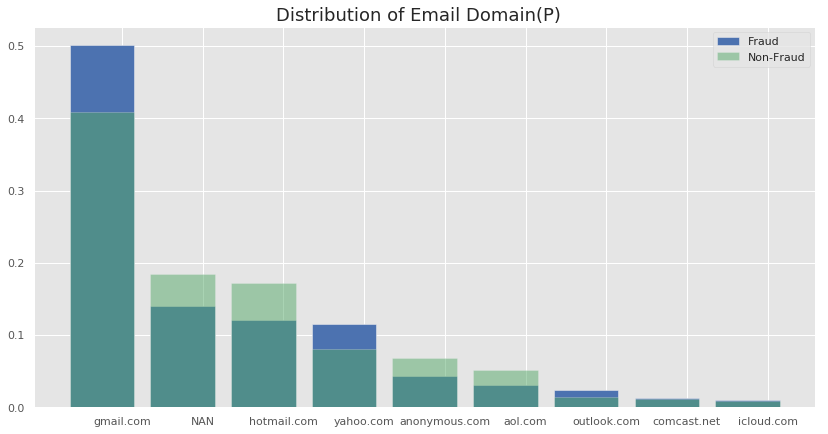

In [0]:
x = df_transaction_fraud["P_emaildomain"]
y = df_transaction_nonfraud["P_emaildomain"]
get_bar_p(x,y)
plt.title("Distribution of Email Domain(P)  ", fontsize=18)  
plt.show()

In [0]:
def get_chart(fraud):
    if fraud == True:
        temp = df_transaction_fraud["P_emaildomain"]
    else:
        temp = df_transaction_nonfraud["P_emaildomain"]
    temp = temp.fillna("NAN")
    df_temp= temp.value_counts()
    df_temp = df_temp.reset_index()
    df_temp = df_temp.sort_values(by="P_emaildomain", ascending=False)
    # Find Percentage
    df_temp["Percentage"] = round(100 * df_temp["P_emaildomain"] / sum(df_temp["P_emaildomain"]), 2)
    df_temp = df_temp[0:8]
    sns.set()
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    style.use('ggplot')
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = df_temp['index']
    sizes = df_temp['Percentage']
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, colors = colors,startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.   

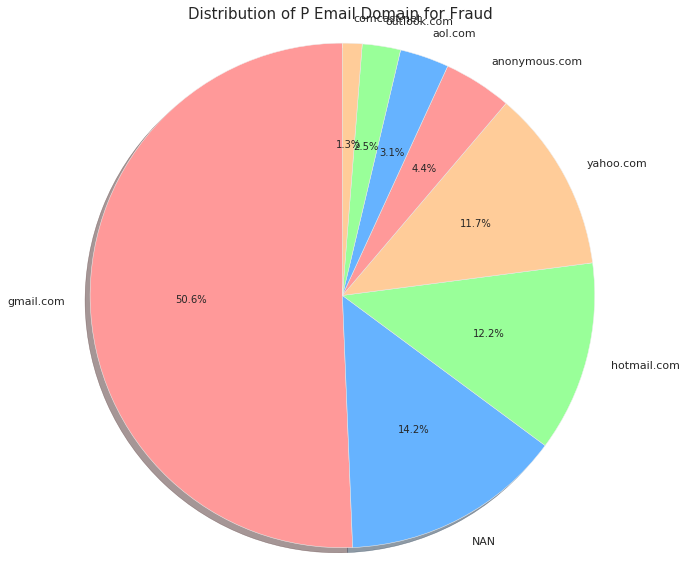

In [0]:
get_chart(True)
plt.title("Distribution of P Email Domain for Fraud ", fontsize=15) 
plt.show()

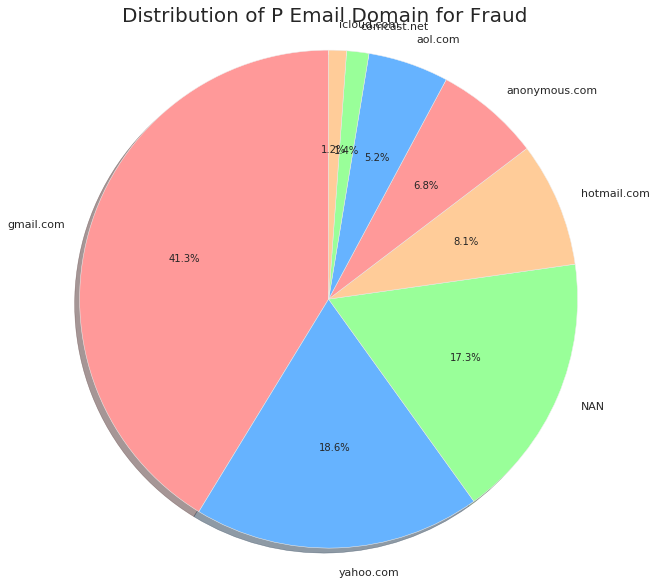

In [0]:
get_chart(False)
plt.title("Distribution of P Email Domain for Fraud ", fontsize=20) 
plt.show()

#### R_Email Domain

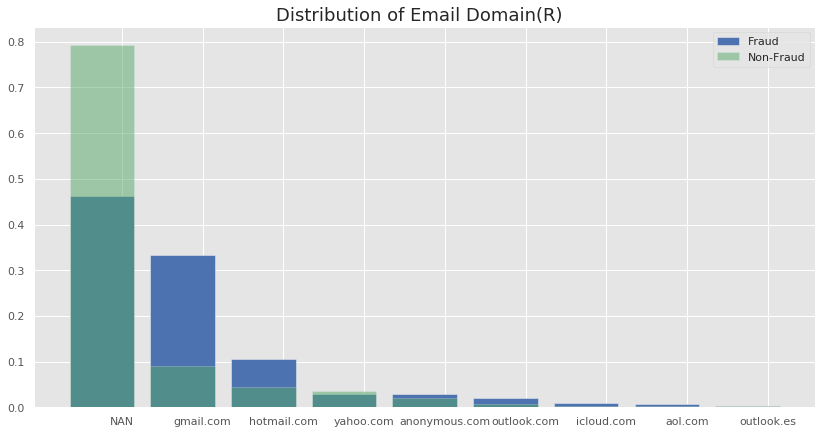

In [0]:
x = df_transaction_fraud["R_emaildomain"]
y = df_transaction_nonfraud["R_emaildomain"]
get_bar_p(x,y)
plt.title("Distribution of Email Domain(R)  ", fontsize=18)  
plt.show()

#### addr1/ addr2

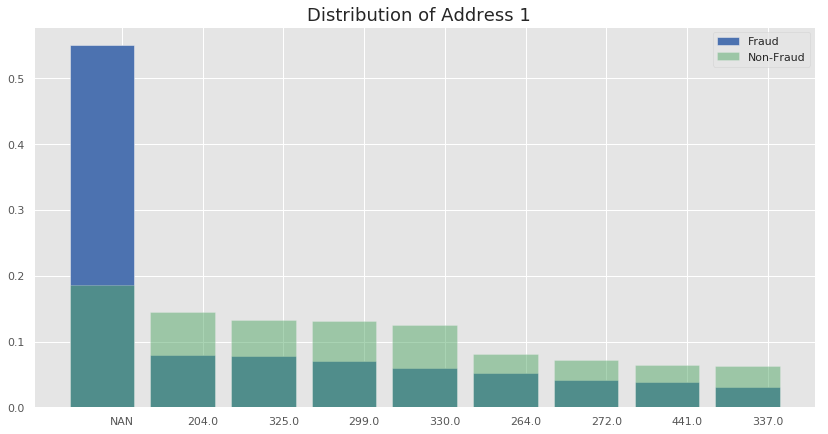

In [0]:
x = df_transaction_fraud["addr1"]
y = df_transaction_nonfraud["addr1"]
get_bar_p(x,y)
plt.title("Distribution of Address 1  ", fontsize=18)  
plt.show()

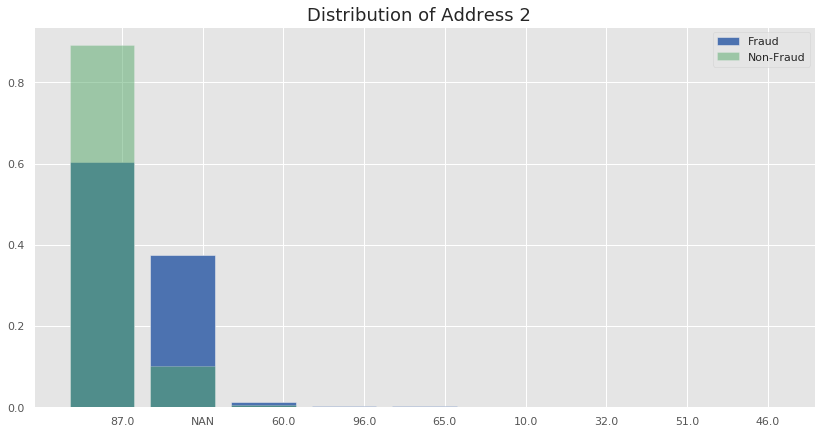

In [0]:
x = df_transaction_fraud["addr2"]
y = df_transaction_nonfraud["addr2"]
get_bar_p(x,y)
plt.title("Distribution of Address 2  ", fontsize=18)  
plt.show()

Text(0.5, 1.0, 'Probability Density of address (addr1)')

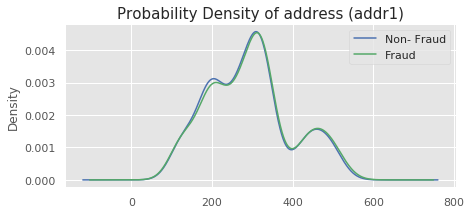

In [0]:
df_TransactionID =  pd.DataFrame({'Non- Fraud': df_transaction_nonfraud["addr1"],'Fraud': df_transaction_fraud["addr1"]})
plt.rcParams['figure.figsize'] = (7.0, 3.0)
ax = df_TransactionID.plot.kde(bw_method=0.3)
plt.title('Probability Density of address (addr1)', fontsize=15)  

#### Dist1 / Dist2

Text(0.5, 1.0, 'Probability Density of address (dist1)')

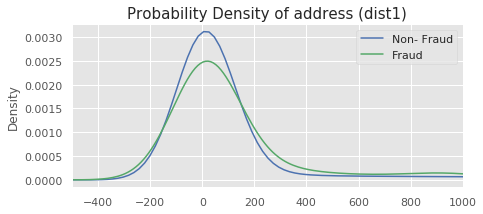

In [0]:
df_TransactionID =  pd.DataFrame({'Non- Fraud': df_transaction_nonfraud["dist1"],'Fraud': df_transaction_fraud["dist1"]})
ax = df_TransactionID.plot.kde(bw_method=0.3)
ax.set(xlim=(-500, 1000))
plt.title('Probability Density of address (dist1)', fontsize=15)  

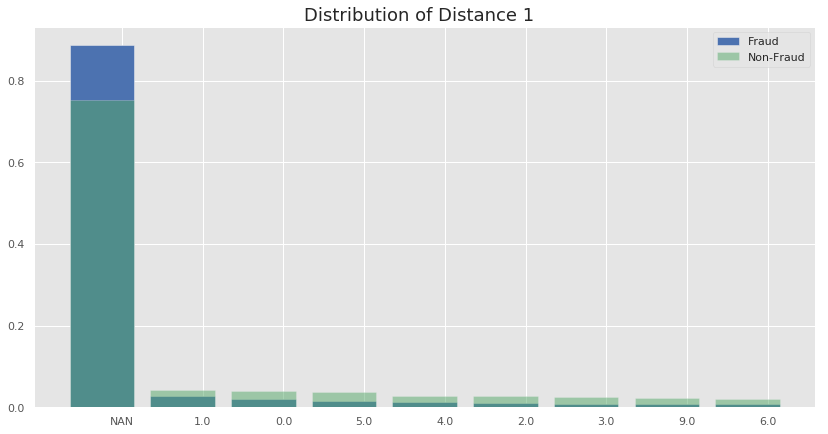

In [0]:
x = df_transaction_fraud["dist1"]
y = df_transaction_nonfraud["dist1"]
get_bar_p(x,y)
plt.title("Distribution of Distance 1  ", fontsize=18)  
plt.show()

**Part 1 Answer**

1. The percentage of mobile phones used for all fraudulent Transactions is higher than the percentage of mobile phones used for Fraudulent Transactions. 
2. If we look at the distribution of Device Info, we find that apart from the most common smartphone brands, we see devices like - hi6210sft Build/MRA58K which is a lower end Huawei phone and LG Phones which don’t appear in the list of most common phones for Non - Fraudulent transactions. 
3. Product (CD) category C has higher number of Fraudulent Transactions than any other category, where as Product code W is the most frequent item for non fraudulent transactions that has an insignificant percentage in the non fraudulent category . 
4. Addr1 field is missing for most fraudulent cases. This could indicate that the fraudulent transactions have restricted permissions and don't allow access to address details.  
5. The percentage of fraudulent transactions that use credit cards is higher than non fraudulent transactions. There is a significantly higher percentage of non fraud transactions that use debit cards over credit cards. 
6. The distribution of fraudulent transactions and non fraulent transaction is skewd. 99% of the samples correspond to Non Fraudulent transactions. 
7. In most cases we find that Fraudent transactions have a higher probability of NAN values for details such as Address, Distance and email addresses, the only exeption to this pattern is the device type. 








## Part 2 - Transaction Frequency

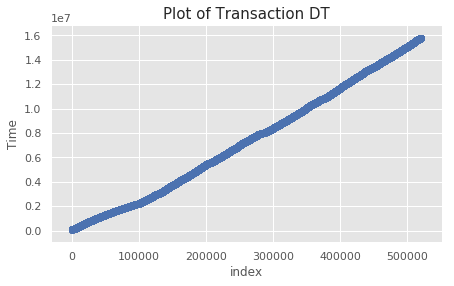

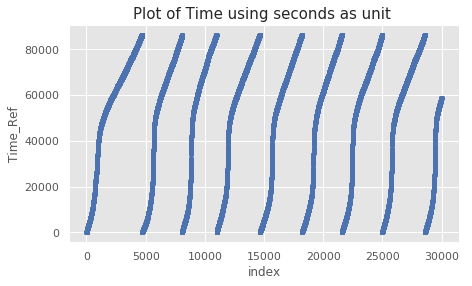

In [0]:
high_freq_area = df_transaction_limited['addr2'].mode()
df_time = pd.DataFrame({'TransactionID':df_transaction_limited['TransactionID'],'Time': df_transaction_limited['TransactionDT'], 'addr2': df_transaction_limited['addr2']})
df_temp = df_time.loc[df_time['addr2'] == 87.0]

# For total number of seconds ina day 86400
df_temp['index'] = np.arange(len(df_temp))
# Only taking seconds as the unit we get a periodic graph, not for minutes or miliseconds
# 86400 is the number of seconds in a day 
plt.rcParams['figure.figsize'] = (7.0, 4)
df_temp['Time_Ref'] = df_temp['Time'] % (86400)
df_temp.plot(x ='index', y='Time', kind = 'scatter')
plt.title('Plot of Transaction DT', fontsize=15)  
plt.scatter(df_temp['index'], df_temp['Time'],  alpha=0.5); 
plt.show()

df_temp.iloc[0:30000].plot(x = 'index', y='Time_Ref',kind = 'scatter')
plt.title('Plot of Time using seconds as unit ', fontsize=15)
plt.show()

We notice that Delta time is monotonically Increasing, we need to find out which unit of time it corresponds to observe the periodic nature that might occur due to sleeping and waking hours of country.

The unit of time likely to be used would be either minutes or seconds 

We observe that if we take the modulus with the number of seconds in a day we get a periodic graph and not with other units like minutes or miliseconds. 
Every day has 86400 units (seconds)

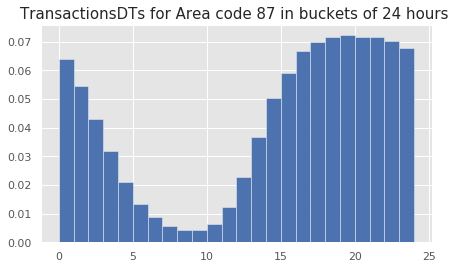

In [0]:

#  For one Particular Day, plot the distribution 
# our day is approximateley - 5000 units 
df_x = df_temp['Time_Ref'] / 60/60
df_x.hist(density = True, bins = 24)
plt.title('TransactionsDTs for Area code 87 in buckets of 24 hours ', fontsize=15)
plt.show()

**Part 2 - Answer**

1. We notice that Delta time is monotonically Increasing, and as per the description it is the time delta from a particular point in time. The lowest value of TransactionDT in the Dataset is 86400.

2. We need to find out which unit of time it corresponds to observe the periodic nature that might occur due to sleeping and waking hours of country.The unit of time likely to be used would be either minutes or seconds for a rational timestamp. 

3. We observe that if we take the modulus with the number of seconds in a day we get a periodic graph and not with other units like minutes or miliseconds. Every day has 86400 units (seconds)

4. We transform the time to represent the hour of the day by taking the modulus with the seconds in a day and dividing it by 3600. 

5. We filter the transactions by Area code as we do not know if all the areas lie in the same timezone. Now we have time in buckets of one hour. We plot the distribution of transaction time in hours to find out the hours in which customers shop the most that would corresspond to the waking hours of teh country.

6. For Country Code '87' Hours 9 and 10 have the minimum frequency of transactions if we start the clock from hour 1 and go uptil 24. On an average a person sleeps for 7-8 hours a day.  So our sleeping hours would be roughly 5:00 to 13:00. Peak waking hours would be 14:00 to 24:00 and (union) 1:00 to 2:00. 

## Part 3 - Product Code

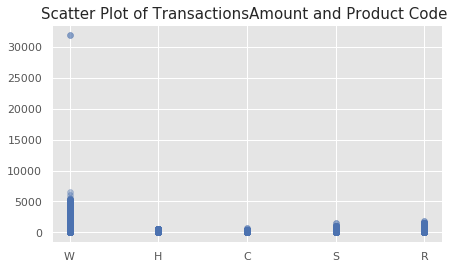

          TransactionAmt                          ...                             
                   count        mean         std  ...      50%      75%        max
ProductCD                                         ...                             
C                68519.0   42.872353   38.943070  ...   31.191   54.102    712.896
H                33024.0   73.170058   61.950955  ...   50.000  100.000    500.000
R                37699.0  168.306188  142.035568  ...  125.000  200.000   1800.000
S                11628.0   60.269487   80.546775  ...   35.000   80.000   1550.000
W               439670.0  153.158554  268.733692  ...   78.500  146.000  31937.391

[5 rows x 8 columns]


In [0]:
# code to analyze prices for different product codes
x = df_transaction_limited['ProductCD']
y = df_transaction_limited['TransactionAmt']
plt.scatter(x,y , label  = 'Transaction_amount', alpha = 0.4 )
plt.title('Scatter Plot of TransactionsAmount and Product Code ', fontsize=15)
plt.show()

df_temp = pd.DataFrame({'ProductCD': x, 'TransactionAmt': y})
gk = df_temp.groupby('ProductCD')
print(gk.describe())


Text(0.5, 1.0, ' Plot of Max TransactionsAmount for Product Codes ')

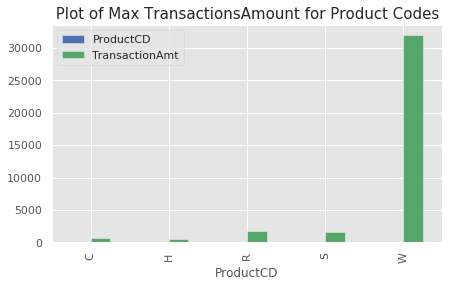

In [0]:
x = df_temp.groupby(['ProductCD'])['TransactionAmt'].max()
dp = pd.DataFrame(x, columns=['ProductCD','TransactionAmt'])
dp.plot( kind = 'bar')
plt.title(' Plot of Max TransactionsAmount for Product Codes ', fontsize=15)

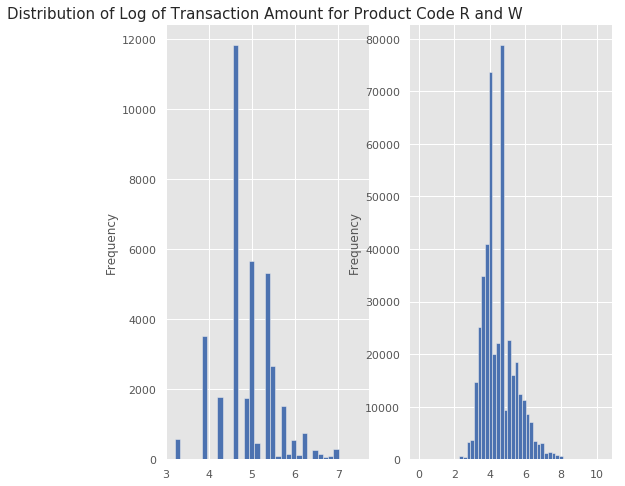

In [0]:
plt.rcParams['figure.figsize'] = (6.0, 10.0)
plt.figure()

product_unique = np.unique(x)
plt.subplot(121)
temp = df_transaction_limited[df_transaction_limited['ProductCD'] == 'R']
temp1=np.log(temp['TransactionAmt'])
temp1.plot.hist(bins=(1800-15)//50, figsize=(8,8), rwidth = 20)
plt.title('Distribution of Log of Transaction Amount for Product Code R and W ', fontsize=15)


product_unique = np.unique(x)
plt.subplot(122)
temp = df_transaction_limited[df_transaction_limited['ProductCD'] == 'W']
temp1=np.log(temp['TransactionAmt'])
temp1.plot.hist(bins=50, figsize=(8,8), rwidth = 20)
#plt.title('Distribution of log of Transaction Amount for Product Code W ', fontsize=15)
plt.show()
    

# Part 3 - Answer ###
R and W correspond to expensive products as the mean of these products is 168 Units and 153Units . W also has the most expensive product but the standard deviation is high and prices are thus spread out over the range (1- 31944). 
W has a lot more products than R and thus has a larger number of higher valued products but the mean of a majority (75%) of the products in R is much higher than W. Indicating R doesn't have products with lower prices. Likewise the cheapest products are C and S as their means 42 USD and 60 USD respectively. From the histogram we observe that the values of C are not spread out and it has the lowest standard deviation of 38. Thus C could arguably be the cheapest product code. 

## Part 4 - Correlation Coefficient

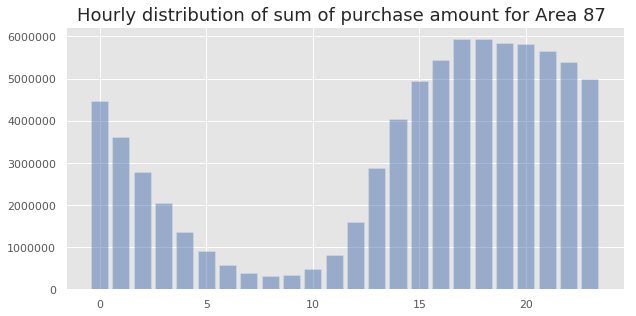

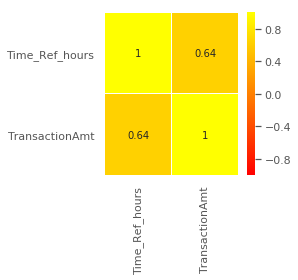

In [0]:

# Time of day in bucketted in hours , sum of purchase amount in that hour 

df_temp = df_transaction_limited[['TransactionDT', 'TransactionAmt', 'addr2']]
df_temp = df_temp.loc[df_temp['addr2'] == 87.0]
df_temp['Time_Ref'] = df_temp['TransactionDT'] % (86400) 
df_temp['Time_Ref_hours'] = (df_temp['Time_Ref']/60)//60

x = df_temp.groupby(['Time_Ref_hours'])['TransactionAmt'].sum()
x = x.reset_index()
x_a = x['Time_Ref_hours']
y_a = x['TransactionAmt']
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.bar(x_a, y_a,   alpha=0.5)
plt.gcf().subplots_adjust(bottom=0.15)
plt.title("Hourly distribution of sum of purchase amount for Area 87 ", fontsize=18)    
plt.show()

# calculate correlation coefficient
corr = x.corr(method = 'spearman')
plt.figure(figsize=(3,3))
sns.heatmap(corr, vmin=-1, vmax=1, cmap='autumn', linewidths=0.2, annot=True)


# **Part 4 Answer** 
Correlation been the hour of the day( 0 - 24) and  Sum of all transactions during that period is 0.64, calculated using the spearman correlation. It is intuitive that these two parameters show a good positive correlation. The time of the day would certainly dictate when people shop. People mostly do not shop after dinner time at night and shop more during the eveining. 

---


We process 'TransactionDT' field to generate the time reference field that put all transactions into buckets corresponding to the hour of the day. We group out dataset by these buckets and find the sum of all transactions during the bucket across all days. We find the plot similar to our plot of histrogram of the time buckets. It also shows the waking hours and shopping peak hours. 

## Part 5 - Interesting Plot

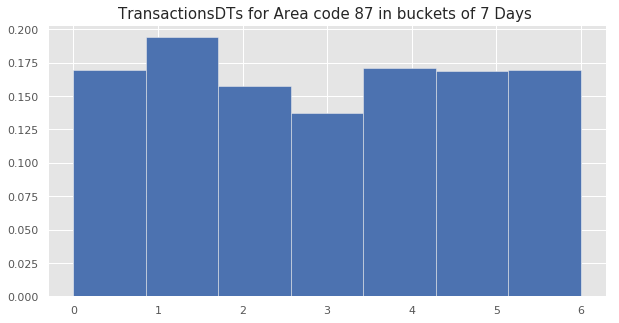

In [0]:

# Create a plot of your own using the dataset that you think reveals something very interesting.
# Explain what it is, and anything else you learned.

# Weekend Shopping Trends 

df_temp['weekday'] = df_temp['TransactionDT'].map(lambda x:(x //(3600 * 24)) % 7)
df_temp['weekday'].hist(density = True, bins = 7)
plt.title('TransactionsDTs for Area code 87 in buckets of 7 Days ', fontsize=15)
plt.show()

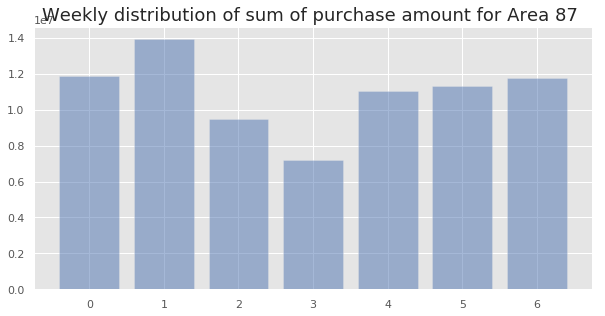

In [0]:
x = df_temp.groupby(['weekday'])['TransactionAmt'].sum()
x = x.reset_index()
x_a = x['weekday']
y_a = x['TransactionAmt']
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.bar(x_a, y_a,   alpha=0.5)
plt.gcf().subplots_adjust(bottom=0.15)
plt.title("Weekly distribution of sum of purchase amount for Area 87 ", fontsize=18)    
plt.show()

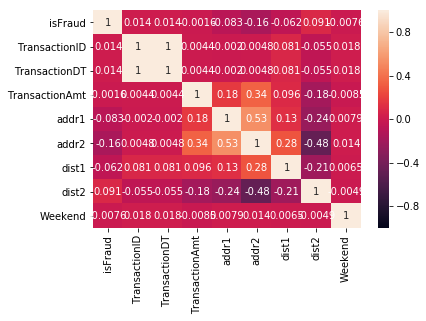

In [0]:
corr = df_transaction_limited.corr(method = 'spearman')
ax = sns.heatmap(corr, vmin=-1, vmax=1,  annot=True)


# **Part 5 Answer**

To observe the Shopping trend and variations over the week we bucket time into days of the week and plot it. We find that on one of the days the total number of transactions as well as sum off transactions exceeds all other. This might correspond to one day of the weekend. As we are not sure if the buckets clearly demarkate the start of the day, it might be a combination of two days. We can also observe the correalation of the new feature we engineered - weekend with the labels and other categories. 

## Part 6 - Prediction Model

In [0]:
import pandas as pd
import io
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
from scipy import special, optimize
from matplotlib import style
from collections import Counter
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from numpy import loadtxt


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
from google.colab import files
uploaded_c = files.upload()

Saving train_transaction.csv.zip to train_transaction.csv.zip
Saving train_identity.csv.zip to train_identity.csv.zip


In [0]:
df_train_identity = pd.read_csv('train_identity.csv.zip')
df_train_transaction = pd.read_csv('train_transaction.csv.zip')
df_all = pd.merge(df_train_identity,df_train_transaction , on='TransactionID',how = 'outer')

In [0]:
def normalise_col(col_name):
    x = df_all[[i]].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_normalized = pd.DataFrame(x_scaled)
    df_all[i] = df_normalized
    
def ordinal_encoding(col_names):
    for i in col_names:
        df_all[i] = pd.Categorical(df_all[i])
        df_all[i] = df_all[i].cat.codes


In [0]:
#1 Drop Transaction ID and colums with highest number of NAN values and modify Transaction DT 
#Train Set 
df_all['TransactionDT'] = df_all['TransactionDT'] % (86400)
df_all['TransactionDT'] = df_all['TransactionDT'] /60/60

# 2 Remove Columns with most NANs
df_rm = df_all.isnull().sum()
df_rm = pd.DataFrame({'col':df_rm.index, 'NANsum':df_rm.values})
df_rm = df_rm.sort_values(by=['NANsum'], ascending = False)
df_rm = df_rm[0:260]
to_rem = df_rm["col"].tolist()
df_all = df_all.drop(columns=to_rem)

# 3 Drop Rows with more than 50 missing Features
df_all = df_all.dropna(thresh=50)
# Ordinal Encoding For Categories
col_names = [ 'ProductCD', 'card4', 'card6']
ordinal_encoding(col_names)
  
# 4 Filling Missing Values with Median
df_all = df_all.fillna(df_all.median())

# 5 One Hot Encoding for Categorical Variables 
df_all = pd.get_dummies(df_all, prefix_sep = "_", columns = [ 'ProductCD', 'card4', 'card6'])
  
# 6 Normalise Values in the dataset using min and max of each column
temp =  list(df_all)
normalise_col(temp)


In [0]:
# 5 Split Dataset into train and test 
X = df_all.drop(columns='isFraud')
y = df_all['isFraud'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train, X_test, y_train, y_test write to csv 

NameError: ignored

In [0]:
# 6 Use SMOTE - Over Sampling Technique to Increase the number of Non - Fraud Samples

print(" counts of label '1': {}".format(sum(y_train==1)))
print(" counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

 counts of label '1': 16530
 counts of label '0': 455902 



In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [0]:
clf = RandomForestClassifier(n_estimators=250, max_depth=70,random_state=5)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.92      0.45      0.60      4133

    accuracy                           0.98    118108
   macro avg       0.95      0.72      0.80    118108
weighted avg       0.98      0.98      0.98    118108



# **Part 6 Answer** 

**Accuracy**

Accuracy is 0.98 on our Test set. 
Accuracy of the model here is measures using the weighted F1 score ( Harmonic Mean between precision and recall). Other metrics are Precision calculted by true positives divided by sum of true positives and false positives. 

**Preprocessing** 

Feature Engineering

1. Loaded the entire data set, dropped columns that have 90% values missing.
Removed rows that have more than 50 features missing.
2. Formatted TransactionDT to represent hour of the day, added a column Weekend to meaningfully represent time. 
3. Used median to impute values for missing NAN Fields.
4. Used one hot encoding to make Categorical data more expressive and quantify the categories accurately.
5. SMOTE - Synthetic oversampling is used because the Non Fraudulent class has 96% samples and dominated the dataset. SMOTE synthesises new minority instances between existing (real) minority instances. 

**Model Selection**

1. The models used here is Random forest. Random forest is an ensemble model based on decision trees. The random forest model combines combining decision trees with the notion of an ensemble where mutiple decision trees vote on the classification task. When a new input is entered into the system, it is run down all of the trees. The result in the case of categorical variables is a voting majority.

2. These models are suited to classification tasks with large number of parameters that are a mix of both numerical and categorical data. Random forest handles sparse values and maintains accuracy of large proportion of data. The results obtained on the kaggle challenge are also better for Random forest.

3. Parameters of the Classfier are - n_estimators=250, max_depth=70,random_state=5.
 n_estimators : The number of trees in the forest
 max_depth : The maximum depth of the tree
 
4. Other Models tried were LightGBM, Logistic Regression and SVM. Random forrest performed better.



**Part 7**

In [0]:
from google.colab import files
uploaded_test = files.upload()

Saving test_identity.csv.zip to test_identity.csv.zip
Saving test_transaction.csv.zip to test_transaction.csv.zip
Saving sample_submission.csv.zip to sample_submission.csv.zip


In [0]:
import io
# Preprocess Test files 
df_test_id = pd.read_csv('test_identity.csv.zip')
df_test = pd.read_csv('test_transaction.csv.zip')
df_t = pd.merge(df_test,df_test_id , on='TransactionID', how = 'outer')

Discuss most positive and negative correlations.

In [0]:
# Drop columns and modify transactionDT
df_t['TransactionDT'] = df_t['TransactionDT'] % (86400)
df_t['TransactionDT'] = df_t['TransactionDT'] /60/60
df_t = df_t.drop(columns=to_rem)
# Change text columns to ordinal Encoding 
col_names = [ 'ProductCD', 'card4', 'card6']
for i in col_names:
  df_t[i] = pd.Categorical(df_t[i])
  df_t[i] = df_t[i].cat.codes
# Fill NAN with medians of the column 
df_t = df_t.fillna(df_t.median())
# One Hot Encoding for categorical Variables 
df_t = pd.get_dummies(df_t, prefix_sep = "_", columns = [ 'ProductCD', 'card4', 'card6'])
# Normalise all values 
for i in list(df_t):
  x = df_t[[i]].values.astype(float)
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df_normalized = pd.DataFrame(x_scaled)
  df_t[i] = df_normalized


In [0]:
print(X_train.shape)
print(df_t.shape)

def Diff(li1, li2): 
    return (list(set(li1) - set(li2))) 
  
# Driver Code 
li1 =  list(df_all)
li2 = list(df_t)
print(Diff(li1, li2))

(472432, 185)
(506691, 184)
['isFraud', 'card6_3']


In [0]:
df_t['card6_3'] = 0

In [0]:
predictions = clf.predict(df_t)

In [0]:
submission = pd.read_csv('sample_submission.csv.zip')
submission['isFraud'] = predictions
submission.to_csv('submission00.csv', index=False)
!cp 'submission00.csv' drive/My\ Drive/

## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/shubhangikishore/[Kaggle_Profile](https://www.kaggle.com/shubhangikishore)

Highest Rank: 5567

Score: 0.6952

Number of entries: 6

Score Image Link: [link text](https://drive.google.com/file/d/1VlFhEwEhPgvmT7Biq307AKoIXgzb31sR/view?usp=sharing)